# Dog Breed classification
## Using Pytorch and sagemaker


In this notebook, we will make the first steps towards developing an algorithm that is part of a web application, that we are going to implement in last with the use lambda and api gateway.

## Main Goal:
If a dog is detected in the image, it will provide an estimate of the dog's breed. If a human is detected, it will provide an estimate of the dog breed that is most resembling.

### General Outline
1. Download or otherwise retrieve the data.
2. Explore the data
3. Preprocess the data
4. Design th model and create model.py in train folader and in server folder
5. Create training and testing function for data
6. create loss functon and train data on own CNN method
7. test the mdel on test data
8. create transfer learning method in model.py in both folders to train data on pretrained models.
9. fit the data through the sagemaker
8. Hyperparameter tuning
9. update model and deploy
10. test model on test dataset
11. Compare both models
12. Create detectors to create human and dogs correctly
12. Create predict.py to predict data with best model.
13. Create Lambda function to deploy web app.
14. deploy api
15. create html file and test api.




# Download the data

In [59]:
%mkdir ../data
# dog images
!wget -O ../data/dogImages.zip https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip ../data/dogImages.zip -d ../data

# human images

!wget -O ../data/lfw.zip https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
!unzip ../data/lfw.zip -d ../data

--2020-11-05 19:19:47--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.117.56
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.117.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘../data/dogImages.zip’

../data/dogImages.z 100%[===================>]   1.05G  13.9MB/s    in 1m 51s  

2020-11-05 19:21:38 (9.72 MB/s) - ‘../data/dogImages.zip’ saved [1132023110/1132023110]

Archive:  ../data/dogImages.zip
   creating: ../data/dogImages/
   creating: ../data/dogImages/test/
   creating: ../data/dogImages/train/
   creating: ../data/dogImages/valid/
   creating: ../data/dogImages/test/001.Affenpinscher/
  inflating: ../data/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: ../data/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: ../data/dogIm

## Explore and visualise data

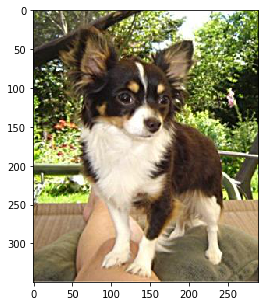

In [33]:
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

image_file = '../data/dogImages/train/048.Chihuahua/Chihuahua_03447.jpg'

pic = imageio.imread(image_file)
plt.figure(figsize = (5,5))
plt.imshow(pic)

In [3]:
print('Type of the image : ' , type(pic)) 
print('Shape of the image : {}'.format(pic.shape)) 
print('Image Hight {}'.format(pic.shape[0])) 
print('Image Width {}'.format(pic.shape[1])) 
print('Dimension of Image {}'.format(pic.ndim))
print('Image size {}'.format(pic.size)) 
print('Maximum RGB value in this image {}'.format(pic.max()))
print('Minimum RGB value in this image {}'.format(pic.min()))
print('Value of only R channel {}'.format(pic[ 100, 50, 0]))
print('Value of only G channel {}'.format(pic[ 100, 50, 1]))
print('Value of only B channel {}'.format(pic[ 100, 50, 2]))

Type of the image :  <class 'imageio.core.util.Array'>
Shape of the image : (350, 290, 3)
Image Hight 350
Image Width 290
Dimension of Image 3
Image size 304500
Maximum RGB value in this image 255
Minimum RGB value in this image 0
Value of only R channel 117
Value of only G channel 112
Value of only B channel 72


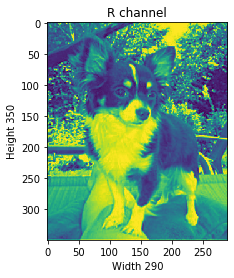

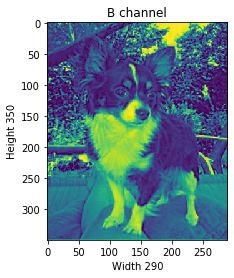

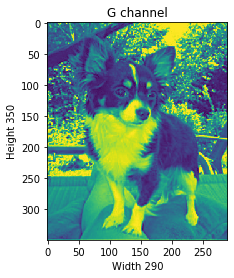

In [4]:
plt.title('R channel') 
plt.ylabel('Height {}'.format(pic.shape[0])) 
plt.xlabel('Width {}'.format(pic.shape[1])) 
plt.imshow(pic[ : , : , 0])
plt.show()

plt.title('B channel') 
plt.ylabel('Height {}'.format(pic.shape[0])) 
plt.xlabel('Width {}'.format(pic.shape[1])) 
plt.imshow(pic[ : , : , 2]) 
plt.show()

plt.title('G channel')
plt.ylabel('Height {}'.format(pic.shape[0])) 
plt.xlabel('Width {}'.format(pic.shape[1])) 
plt.imshow(pic[ : , : , 1]) 
plt.show()

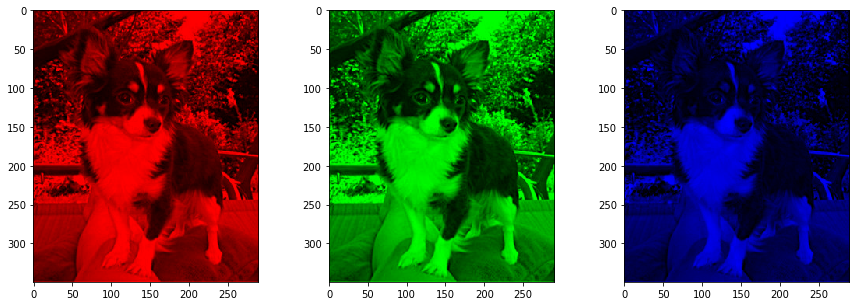

In [5]:
import numpy as np 
pic = imageio.imread(image_file) 
fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))  
for c, ax in zip(range(3), ax):     
     # create zero matrix        
     split_img = np.zeros(pic.shape, dtype="uint8") 
     # 'dtype' by default: 'numpy.float64'  # assing each channel      
     split_img[ :, :, c] = pic[ :, :, c] # display each channel     
     ax.imshow(split_img)

In [3]:
import glob
import pandas as pd


train_image_names = glob.glob('../data/dogImages/train/*/*.jpg')
print("Total number of training images: ", len(train_image_names))

# make train_image_names as serie object
train_image_names = pd.Series(train_image_names)

train_df = pd.DataFrame()

# generate Filename field
train_df['Filename'] = train_image_names.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
train_df['ClassId'] = train_image_names.map(lambda img_name: img_name.split("/")[-2])

train_df.head()


Total number of training images:  6680


Filename                    ClassId
0  Black_russian_terrier_01842.jpg  026.Black_russian_terrier
1  Black_russian_terrier_01838.jpg  026.Black_russian_terrier
2  Black_russian_terrier_01861.jpg  026.Black_russian_terrier
3  Black_russian_terrier_01852.jpg  026.Black_russian_terrier
4  Black_russian_terrier_01821.jpg  026.Black_russian_terrier

In [6]:
!pip install basic-image-eda

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.



found 8351 images.


  0%|          | 0/8351 [00:00<?, ?it/s]

Using 2 threads. (max:2)



100%|██████████| 8351/8351 [03:58<00:00, 35.04it/s]



*--------------------------------------------------------------------------------------*
number of images                         |  8351

dtype                                    |  uint8
channels                                 |  [3]
extensions                               |  ['jpg']

min height                               |  113
max height                               |  4003
mean height                              |  529.0449048018202
median height                            |  467

min width                                |  105
max width                                |  4278
mean width                               |  567.0325709495869
median width                             |  500

mean height/width ratio                  |  0.9330062008886891
median height/width ratio                |  0.934
recommended input size(by mean)          |  [528 568] (h x w, multiples of 8)
recommended input size(by mean)          |  [528 560] (h x w, multiples of 16)
recommended input size(

  0%|          | 5/8351 [00:00<02:54, 47.71it/s]

Using 2 threads. (max:2)



100%|██████████| 8351/8351 [03:23<00:00, 41.00it/s]



*--------------------------------------------------------------------------------------*
number of images                         |  8351

dtype                                    |  uint8
channels                                 |  [3]
extensions                               |  ['jpg']

min height                               |  113
max height                               |  4003
mean height                              |  529.0449048018202
median height                            |  467

min width                                |  105
max width                                |  4278
mean width                               |  567.0325709495869
median width                             |  500

mean height/width ratio                  |  0.9330062008886891
median height/width ratio                |  0.934
recommended input size(by mean)          |  [528 568] (h x w, multiples of 8)
recommended input size(by mean)          |  [528 560] (h x w, multiples of 16)
recommended input size(

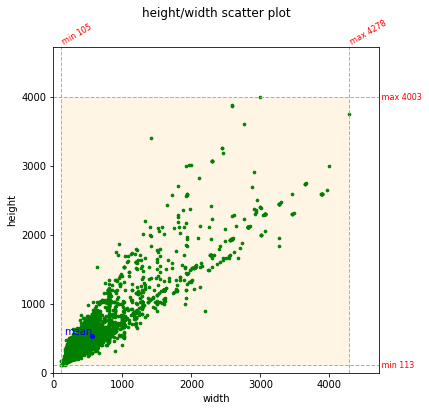

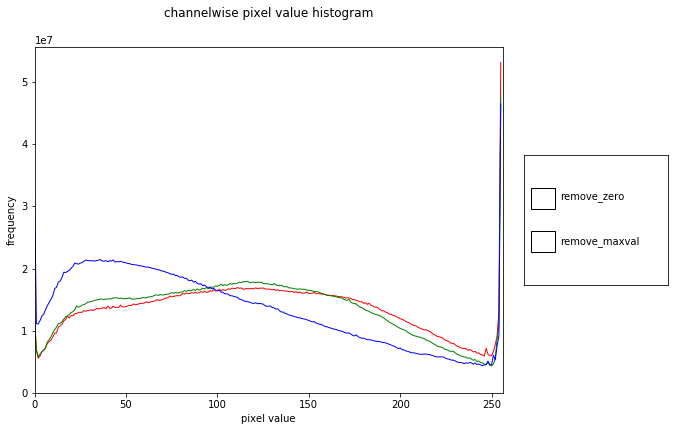

In [7]:
from basic_image_eda import BasicImageEDA

if __name__ == "__main__":  # for multiprocessing
    data_dir = "../data/dogImages"
    BasicImageEDA.explore(data_dir)

    # or

    extensions = ['jpg']
    threads = 0
    dimension_plot = True
    channel_hist = True
    nonzero = False
    hw_division_factor = 1.0

    BasicImageEDA.explore(data_dir, extensions, threads, dimension_plot, channel_hist, nonzero, hw_division_factor)

### No. of images in each class

In [4]:
train_df.groupby('ClassId')['Filename'].nunique().describe()

ClassId
001.Affenpinscher                  64
002.Afghan_hound                   58
003.Airedale_terrier               52
004.Akita                          63
005.Alaskan_malamute               77
                                   ..
129.Tibetan_mastiff                48
130.Welsh_springer_spaniel         44
131.Wirehaired_pointing_griffon    30
132.Xoloitzcuintli                 26
133.Yorkshire_terrier              30
Name: Filename, Length: 133, dtype: int64

In [5]:
train_df.groupby('ClassId')['Filename'].nunique().describe()

count    133.000000
mean      50.225564
std       11.863885
min       26.000000
25%       42.000000
50%       50.000000
75%       61.000000
max       77.000000
Name: Filename, dtype: float64

## Prepare and Preprocess the data

1. load and divide dog images into train, valid, test
2. extract labes and divide respectively
3. Transform data

In [1]:
import os

data_dir = '../data/dogImages/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

In [2]:
import torchvision.transforms as transforms

standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'val': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])
                  }

In [3]:
from torchvision import datasets

train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_data = datasets.ImageFolder(valid_dir, transform=data_transforms['val'])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

In [4]:
import torch

num_workers = 0
batch_size = 20


trainloader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
validationloader = torch.utils.data.DataLoader(val_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
testloader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
all_loaders= {
    'train': trainloader,
    'valid': validationloader,
    'test': testloader
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

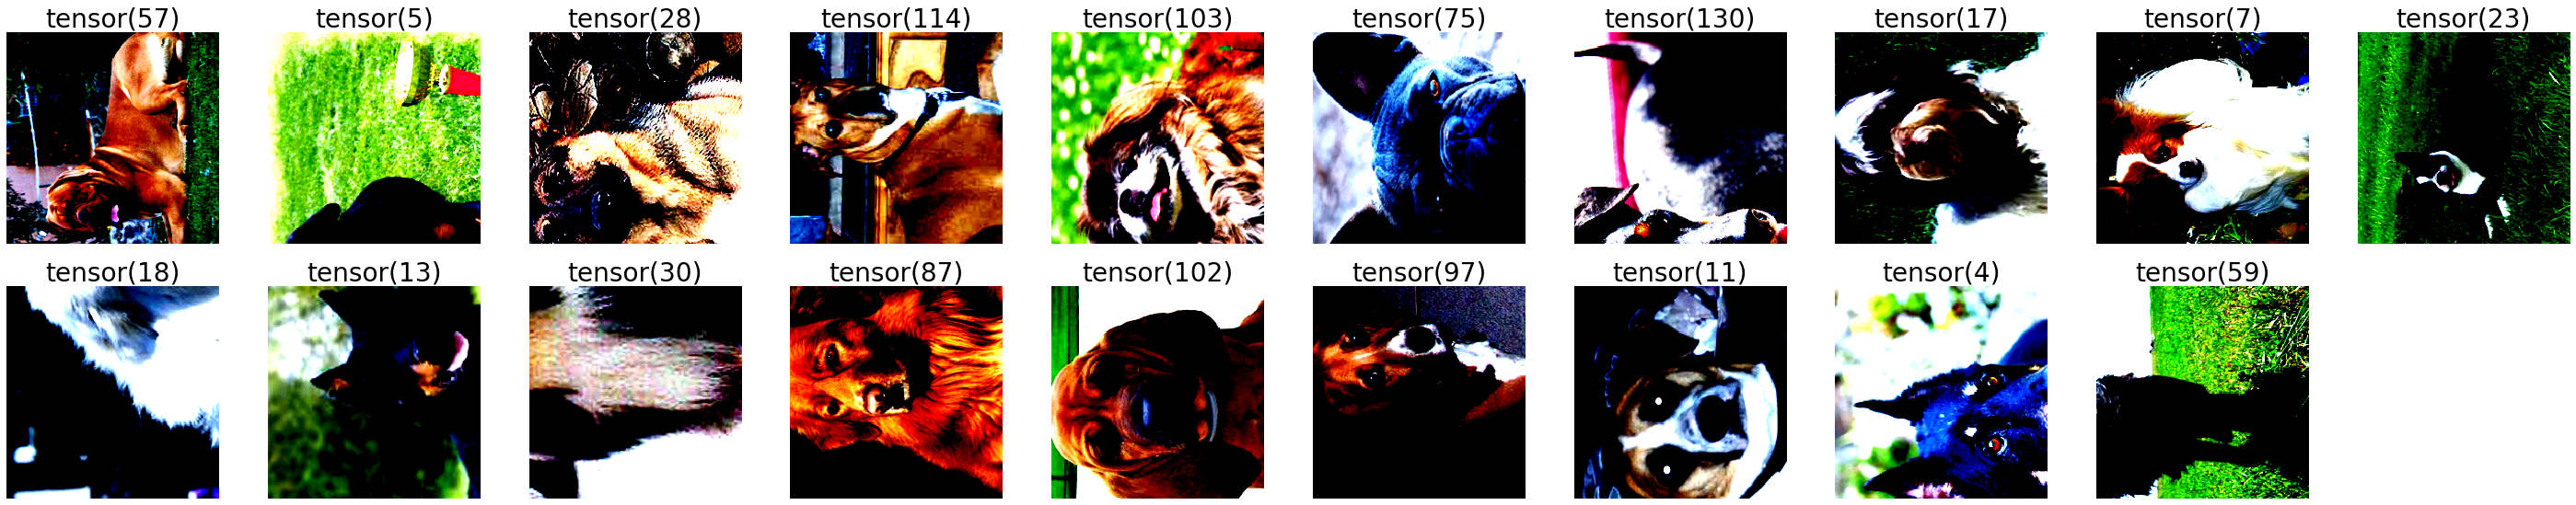

In [25]:
import matplotlib.pyplot as plt
how_many_to_plot = 20

images, labels = next(iter(all_loaders['train']))

plt.figure(figsize=(50,50))
for i in range(1,how_many_to_plot):
    image = images[i]
    plt.subplot(10,10,i)
    plt.imshow(image.T, cmap='gray')
    plt.axis('off')
    plt.title(label[i], fontsize=28)
plt.show()

## Design pytorch cnn model

In [10]:
!pygmentize train/model.py

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class BreedClassifier(nn.Module):
    def __init__(self):
        super(BreedClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        # pool
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully-connected
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 133) 
        
        # drop-out
        self.dropout = nn.Dropout(0.3)
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.p

In [11]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model.forward(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ###################### 
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
    
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model.forward(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        # Save model if validation loss has decreased since last min
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [12]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [11]:
from train.model import BreedClassifier
import torch
model_scratch = BreedClassifier()
print(model_scratch)

use_cuda = torch.cuda.is_available()

if use_cuda:
    model_scratch.cuda()

BreedClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=133, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [14]:
!pip install torchviz

     |████████████████████████████████| 41 kB 21 kB/s  eta 0:00:011
  Created wheel for torchviz: filename=torchviz-0.0.1-py3-none-any.whl size=3521 sha256=ec3e5994326019b4348dbcffe8a0a78e67fba58e68093a9cca3adf9f75334d27
  Stored in directory: /home/ec2-user/.cache/pip/wheels/e8/16/a6/06a007dacdd58a588db06333a7da7e571b792fbd6cf5bccafb
Successfully built torchviz
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


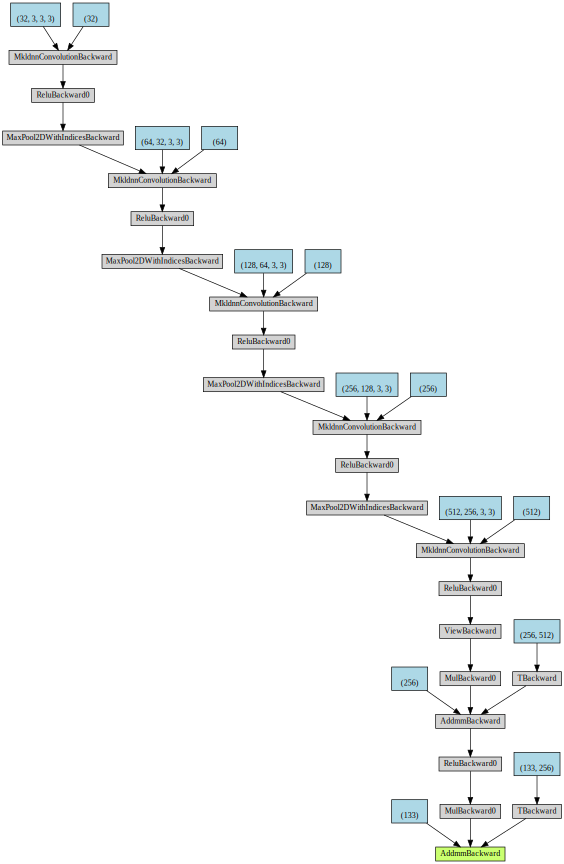

In [18]:
from torchviz import make_dot

x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
out = model_scratch(x)
make_dot(out)

In [ ]:
import torch.optim as optim
import torch.nn as nn
import numpy as np

#OSError: image file is truncated (150 bytes not processed)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.05)

model_scratch = train(10, all_loaders, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model.pt')

Epoch: 1 	Training Loss: 4.887699 	Validation Loss: 4.883605
Validation loss decreased (inf --> 4.883605).  Saving model ...
Epoch: 2 	Training Loss: 4.880974 	Validation Loss: 4.879013
Validation loss decreased (4.883605 --> 4.879013).  Saving model ...
Epoch: 3 	Training Loss: 4.876181 	Validation Loss: 4.875358
Validation loss decreased (4.879013 --> 4.875358).  Saving model ...
Epoch: 4 	Training Loss: 4.871427 	Validation Loss: 4.871844
Validation loss decreased (4.875358 --> 4.871844).  Saving model ...
Epoch: 5 	Training Loss: 4.867263 	Validation Loss: 4.867119
Validation loss decreased (4.871844 --> 4.867119).  Saving model ...
Epoch: 6 	Training Loss: 4.862203 	Validation Loss: 4.858948
Validation loss decreased (4.867119 --> 4.858948).  Saving model ...
Epoch: 7 	Training Loss: 4.849608 	Validation Loss: 4.830217
Validation loss decreased (4.858948 --> 4.830217).  Saving model ...
Epoch: 8 	Training Loss: 4.818741 	Validation Loss: 4.780703
Validation loss decreased (4.83021

In [17]:
test(all_loaders, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.676004


Test Accuracy:  2% (19/836)


### Now using pretrained model

In [18]:
model_transfer = model_scratch.TransferLearning()


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/ec2-user/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [19]:
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [1]:
!pygmentize train/train.py

import argparse
import torch
import os
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
import torch.nn as nn
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from model import BreedClassifier
import json

def model_fn(model_dir):
    """Load the PyTorch model from the `model_dir` directory."""
    print("Loading model.")
    
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)
    
    print("model_info: {}".format(model_info))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    map_location=lambda storage, loc: storage
    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    model_path = os.path.join(model_dir, 'model.pth')
    
    print("cuda info: {}".format(map_location))
    
    
    model = BreedClassifier()    

In [2]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/dogbreed'

role = sagemaker.get_execution_role()

data_dir = '../data/dogImages/'

In [3]:
%%time
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

CPU times: user 1min 1s, sys: 4.93 s, total: 1min 6s
Wall time: 11min 19s


In [4]:
input_data

's3://sagemaker-us-east-2-012204818795/sagemaker/dogbreed'

In [5]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    framework_version='0.4.0',
                    py_version='py3',
                    instance_count=1,
                    instance_type='ml.p2.xlarge',
                    hyperparameters={
                        'epochs': 10,
                        'batch-size': 20,
                        'worker-class':0,
                        'lr':0.0025
                    })

In [6]:
%%time
estimator.fit({'training': input_data})

2020-11-11 20:04:14 Starting - Starting the training job...
2020-11-11 20:04:16 Starting - Launching requested ML instances......
2020-11-11 20:05:19 Starting - Preparing the instances for training......
2020-11-11 20:06:40 Downloading - Downloading input data.........
2020-11-11 20:08:16 Training - Downloading the training image...
2020-11-11 20:08:37 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-11-11 20:08:39,581 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-11-11 20:08:39,617 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-11-11 20:08:39,623 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-11-11 20:08:40,125 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-11-11 20:08:40,126 sa

### Deploy the model

In [7]:
%%time
estimator_predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------------!CPU times: user 252 ms, sys: 24 ms, total: 276 ms
Wall time: 6min 31s


### Test the model 

In [12]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets

standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

test_dir = os.path.join(data_dir, 'test/')
test_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])
test_data = datasets.ImageFolder(test_dir, transform=test_transform)
testloader = torch.utils.data.DataLoader(test_data,
                                           batch_size=20, 
                                           num_workers=0,
                                           shuffle=False)

In [16]:
import torch.nn as nn
import numpy as np
test_loss = 0.
correct = 0.
total = 0.

criterion_transfer = nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()
for batch_idx, (data, target) in enumerate(testloader):
        # move to GPU
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model

    output = estimator_predictor.predict(data)
    output = torch.from_numpy(output)
    if use_cuda:
        output.cuda()
    # calculate the loss
    loss = criterion_transfer(output, target)
    # update average test loss 
    test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
    # convert output probabilities to predicted class
    pred = output.data.max(1, keepdim=True)[1]
    # compare predictions to true label
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0)

print('Test Loss: {:.6f}\n'.format(test_loss))

print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
    100. * correct / total, correct, total))

Test Loss: 0.420745


Test Accuracy: 87% (731/836)


### Comparing the results

Our Transfer learning model accuracy is 87%

Our design model accuracy is 2%.

So we decided to choose transfer learning for model deployment and further testing

### hyperparameter tuning

In [21]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner


Hyper_tuner = HyperparameterTuner(estimator = estimator,
                                  objective_metric_name="training-acc",
                                  metric_definitions=[{'Name': "training-acc",
                                                       'Regex': 'Validation Loss: (.*)'}],
                                  objective_type = 'Minimize',
                                  max_jobs = 20,
                                  max_parallel_jobs = 1,
                                  hyperparameter_ranges = {
                                        'batch-size' : IntegerParameter(10, 30),
                                        'epochs' : IntegerParameter(10, 30),
                                        'lr'      : ContinuousParameter(1e-3, 0.5),
                                        'worker-class': IntegerParameter(0, 5),
                                          
                                   }
                                )

In [22]:
Hyper_tuner.fit({'training': input_data})

..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................._s


In [23]:
Hyper_tuner.wait()

s


In [24]:
Hyper_tuner.best_training_job()

'sagemaker-pytorch-201105-1523-001-ac830f3e'

In [25]:
best_attached = PyTorch.attach(Hyper_tuner.best_training_job())


2020-11-05 16:15:53 Starting - Preparing the instances for training
2020-11-05 16:15:53 Downloading - Downloading input data
2020-11-05 16:15:53 Training - Training image download completed. Training in progress.


UnexpectedStatusException: Error for Training job sagemaker-pytorch-201105-1523-001-ac830f3e: Stopping. Reason: (No reason provided)

## We stooped tuning jobs as it was taking too much time and cost.

### define label classes

In [31]:
class_names = [item[4:].replace("_", " ") for item in all_loaders['train'].dataset.classes]
class_names[:10]
class_names

['Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute',
 'American eskimo dog',
 'American foxhound',
 'American staffordshire terrier',
 'American water spaniel',
 'Anatolian shepherd dog',
 'Australian cattle dog',
 'Australian shepherd',
 'Australian terrier',
 'Basenji',
 'Basset hound',
 'Beagle',
 'Bearded collie',
 'Beauceron',
 'Bedlington terrier',
 'Belgian malinois',
 'Belgian sheepdog',
 'Belgian tervuren',
 'Bernese mountain dog',
 'Bichon frise',
 'Black and tan coonhound',
 'Black russian terrier',
 'Bloodhound',
 'Bluetick coonhound',
 'Border collie',
 'Border terrier',
 'Borzoi',
 'Boston terrier',
 'Bouvier des flandres',
 'Boxer',
 'Boykin spaniel',
 'Briard',
 'Brittany',
 'Brussels griffon',
 'Bull terrier',
 'Bulldog',
 'Bullmastiff',
 'Cairn terrier',
 'Canaan dog',
 'Cane corso',
 'Cardigan welsh corgi',
 'Cavalier king charles spaniel',
 'Chesapeake bay retriever',
 'Chihuahua',
 'Chinese crested',
 'Chinese shar-pei',
 'Chow cho

### test on single images

In [34]:
from PIL import Image
import torchvision.transforms as transforms
#image path
img_path, img_file = '../data/dogImages/train/115.Papillon', 'Papillon_07439.jpg'
img_path = os.path.join(img_path, img_file)
image = Image.open(img_path).convert('RGB')
standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                 transforms.ToTensor(), 
                                 standard_normalization])

image = prediction_transform(image)[:3,:,:].unsqueeze(0)
idx = torch.argmax(torch.from_numpy(estimator_predictor.predict(image)))
predition = class_names[idx]
print("image_file_name: {0}, \t predition breed: {1}".format(img_path, predition))

image_file_name: ../data/dogImages/train/115.Papillon/Papillon_07439.jpg, 	 predition breed: Papillon


### It predicted accurate result on the file we provided

### Delete the endpoint

In [35]:
estimator_predictor.delete_endpoint()

### Detect if image is dog or human or not valid image

In [36]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("../data/lfw/*/*"))
dog_files = np.array(glob("../data/dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


Number of faces detected: 1


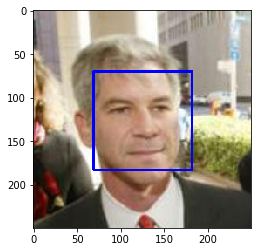

In [37]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
plt.imshow(img)
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [38]:
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms



def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0


use_cuda = torch.cuda.is_available()
VGG19 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    VGG19 = VGG19.cuda()

def dog_detector(img_path):
    # load image
    image = Image.open(img_path).convert('RGB')
    in_transform = transforms.Compose([
                        transforms.Resize(size=(244, 244)),
                        transforms.ToTensor()]) # normalizaiton parameters from pytorch doc.

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    if use_cuda:
        image = image.cuda()
    # predict
    ret = VGG19(image)
    idx =  torch.max(ret,1)[1].item()
    
    return idx >= 151 and idx <= 268

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ec2-user/.cache/torch/checkpoints/vgg16-397923af.pth


### Test the face  and dog face detector

In [39]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

def face_detection_test(files):
    detection_cnt = 0;
    total_cnt = len(files)
    for file in files:
        detection_cnt += face_detector(file)
    return detection_cnt, total_cnt

print("detect face in human_files: {} / {}".format(face_detection_test(human_files_short)[0], face_detection_test(human_files_short)[1]))
print("detect face in dog_files: {} / {}".format(face_detection_test(dog_files_short)[0], face_detection_test(dog_files_short)[1]))



def dog_detector_test(files):
    detection_cnt = 0;
    total_cnt = len(files)
    for file in files:
        detection_cnt += dog_detector(file)
    return detection_cnt, total_cnt


print("detect a dog in human_files: {} / {}".format(dog_detector_test(human_files_short)[0], dog_detector_test(human_files_short)[1]))
print("detect a dog in dog_files: {} / {}".format(dog_detector_test(dog_files_short)[0], dog_detector_test(dog_files_short)[1]))

detect face in human_files: 98 / 100
detect face in dog_files: 16 / 100
detect a dog in human_files: 0 / 100
detect a dog in dog_files: 98 / 100


### Update predict file with detectors

In [53]:
!pygmentize server/predict.py

import argparse
import torch
import os
import io
import PIL.Image as Image
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
import torch.nn as nn
import torch
import torchvision.models as models
import numpy as np
from model import BreedClassifier
import json



from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
VGG16 = models.vgg16(pretrained=True)


def model_fn(model_dir):
    """Load the PyTorch model from the `model_dir` directory."""
    print("Loading model.")
    
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)
    
    print("model_info: {}".format(model_info))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    map_location=lambda storage, loc: storage
    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    model_path = os.pa

### Deploy the model 

In [54]:
from sagemaker.predictor import Predictor
from sagemaker.pytorch import PyTorchModel

class StringPredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='application/x-image')
        
# estimator        
model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='0.4.0',
                     py_version='py3',
                     entry_point='predict.py',
                     source_dir='server',
                     predictor_cls=StringPredictor)
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-----------------!

The class RealTimePredictor has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
content_type is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [56]:
predictor.endpoint

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


'sagemaker-pytorch-2020-11-05-19-09-55-296'

### Testing model endpoint

In [60]:
import json
import numpy as np
import boto3
runtime = boto3.Session().client(service_name='sagemaker-runtime')

img_path, img_file = '../data/dogImages/train/115.Papillon', 'Papillon_07439.jpg'
img_path = os.path.join(img_path, img_file)
image = Image.open(img_path).convert('RGB')
# predictor.predict(image)
img = open(img_path, 'rb').read()

# Call your model for predicting which object appears in this image.
response = runtime.invoke_endpoint(
    EndpointName='sagemaker-pytorch-2020-11-05-19-09-55-296', 
    ContentType='application/x-image', 
    Body=bytearray(img)
)

In [61]:
result = response['Body']
result.read()

b'Dogs Detected!\nIt looks like a Papillon'

# Use the model for the web app

> **TODO:** This entire section and the next contain tasks for you to complete, mostly using the AWS console.

So far we have been accessing our model endpoint by constructing a predictor object which uses the endpoint and then just using the predictor object to perform inference. What if we wanted to create a web app which accessed our model? The way things are set up currently makes that not possible since in order to access a SageMaker endpoint the app would first have to authenticate with AWS using an IAM role which included access to SageMaker endpoints. However, there is an easier way! We just need to use some additional AWS services.

<img src="Web App Diagram.svg">

The diagram above gives an overview of how the various services will work together. On the far right is the model which we trained above and which is deployed using SageMaker. On the far left is our web app that collects a user's movie review, sends it off and expects a positive or negative sentiment in return.

In the middle is where some of the magic happens. We will construct a Lambda function, which you can think of as a straightforward Python function that can be executed whenever a specified event occurs. We will give this function permission to send and recieve data from a SageMaker endpoint.

Lastly, the method we will use to execute the Lambda function is a new endpoint that we will create using API Gateway. This endpoint will be a url that listens for data to be sent to it. Once it gets some data it will pass that data on to the Lambda function and then return whatever the Lambda function returns. Essentially it will act as an interface that lets our web app communicate with the Lambda function.

### Setting up a Lambda function

The first thing we are going to do is set up a Lambda function. This Lambda function will be executed whenever our public API has data sent to it. When it is executed it will receive the data, perform any sort of processing that is required, send the data (the review) to the SageMaker endpoint we've created and then return the result.

#### Part A: Create an IAM Role for the Lambda function

Since we want the Lambda function to call a SageMaker endpoint, we need to make sure that it has permission to do so. To do this, we will construct a role that we can later give the Lambda function.

Using the AWS Console, navigate to the **IAM** page and click on **Roles**. Then, click on **Create role**. Make sure that the **AWS service** is the type of trusted entity selected and choose **Lambda** as the service that will use this role, then click **Next: Permissions**.

In the search box type `sagemaker` and select the check box next to the **AmazonSageMakerFullAccess** policy. Then, click on **Next: Review**.

Lastly, give this role a name. Make sure you use a name that you will remember later on, for example `LambdaSageMakerRole`. Then, click on **Create role**.

#### Part B: Create a Lambda function

Now it is time to actually create the Lambda function.

Using the AWS Console, navigate to the AWS Lambda page and click on **Create a function**. When you get to the next page, make sure that **Author from scratch** is selected. Now, name your Lambda function, using a name that you will remember later on, for example `sentiment_analysis_func`. Make sure that the **Python 3.6** runtime is selected and then choose the role that you created in the previous part. Then, click on **Create Function**.

On the next page you will see some information about the Lambda function you've just created. If you scroll down you should see an editor in which you can write the code that will be executed when your Lambda function is triggered. In our example, we will use the code below. 

```python
# We need to use the low-level library to interact with SageMaker since the SageMaker API
# is not available natively through Lambda.
import boto3
import base64


def lambda_handler(event, context):

    # The SageMaker runtime is what allows us to invoke the endpoint that we've created.
    runtime = boto3.Session().client('sagemaker-runtime')
    encoded_image = event['body'].split(",")[1]
    decoded_image = base64.b64decode(encoded_image)
    print(decoded_image)
    # Now we use the SageMaker runtime to invoke our endpoint, sending the review we were given
    response = runtime.invoke_endpoint(EndpointName = 'sagemaker-pytorch-2020-11-05-19-09-55-296',    # The name of the endpoint we created
                                      ContentType = 'application/x-image',                 # The data format that is expected
                                      Body = bytearray(decoded_image))                       # The actual review

    # The response is an HTTP response whose body contains the result of our inference
    result = response['Body'].read().decode('utf-8')
    
    
    return {
        'statusCode' : 200,
        'headers' : { 'Content-Type' : 'text/plain', 'Access-Control-Allow-Origin' : '*' },
        'body' : result
    }
```

Once you have copy and pasted the code above into the Lambda code editor, replace the `**ENDPOINT NAME HERE**` portion with the name of the endpoint that we deployed earlier. You can determine the name of the endpoint using the code cell below.

## Evaluation and Comparision

Test Loss: 0.428309


Test Accuracy: 86% (725/836)
[[7 0 0 ... 0 0 0]
 [0 7 0 ... 0 0 0]
 [0 0 6 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 3]]
              precision    recall  f1-score   support

         0.0      1.000     0.875     0.933         8
         1.0      1.000     0.875     0.933         8
         2.0      0.750     1.000     0.857         6
         3.0      0.875     0.875     0.875         8
         4.0      0.909     1.000     0.952        10
         5.0      1.000     1.000     1.000         8
         6.0      0.583     1.000     0.737         7
         7.0      1.000     1.000     1.000         8
         8.0      1.000     0.750     0.857         4
         9.0      1.000     1.000     1.000         6
        10.0      1.000     0.778     0.875         9
        11.0      1.000     1.000     1.000         9
        12.0      1.000     1.000     1.000         6
        13.0      0.900     1.000     0.947         9
        14.0      

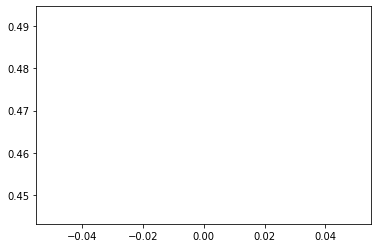

In [15]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets

standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

test_dir = os.path.join(data_dir, 'test/')
test_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])
test_data = datasets.ImageFolder(test_dir, transform=test_transform)
testloader = torch.utils.data.DataLoader(test_data,
                                           batch_size=20, 
                                           num_workers=0,
                                           shuffle=False)

from sklearn import metrics
import torch.nn as nn
import numpy as np
test_loss = 0.
correct = 0.
total = 0.
pred_values = []
target_values = []

criterion_transfer = nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()
for batch_idx, (data, target) in enumerate(testloader):
        # move to GPU
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model

    output = estimator_predictor.predict(data)
    output = torch.from_numpy(output)
    if use_cuda:
        output.cuda()
    # calculate the loss
    loss = criterion_transfer(output, target)
    # update average test loss 
    test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
    # convert output probabilities to predicted class
    pred = output.data.max(1, keepdim=True)[1]
    # compare predictions to true label
    pred_values = np.concatenate((pred_values,pred.cpu().numpy().flatten()))
    target_values = np.concatenate((target_values,target.cpu().numpy()))
    
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0)

print('Test Loss: {:.6f}\n'.format(test_loss))

print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
    100. * correct / total, correct, total))

print(metrics.confusion_matrix(target_values, pred_values))
    # Print the precision and recall, among other metrics
print(metrics.classification_report(target_values, pred_values, digits=3))

### Delete the endpoint

In [62]:
predictor.delete_endpoint()

## Clean 

In [48]:
!rm -rf ../data